In [ ]:
!unzip etl_filtered_v1.zip

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from numpy import arange
import datetime
import seaborn as sns


In [3]:
df = pd.read_csv('etl_filtered_v1.csv')
df = df.drop(['Unnamed: 0'],axis=1)

In [4]:
def get_datetime(row):
  year = row["FIRE_YEAR"]
  doy = row["DISCOVERY_DOY"]
  return datetime.datetime.strptime(f"{year} {doy}", '%Y %j')

def get_month(row):
  year = row["FIRE_YEAR"]
  doy = row["DISCOVERY_DOY"]
  return datetime.datetime.strptime(f"{year} {doy}", '%Y %j').month

In [5]:
df["month"] = df.apply(lambda row: get_month(row), axis=1)

In [6]:
df = df[df["STAT_CAUSE_DESCR"] != 'Missing/Undefined']

In [7]:
df["TAVG"] = (df["TMAX"] + df["TMIN"]) / 2

In [8]:
df["LOG_FIRE_SIZE"] = np.log(df["FIRE_SIZE"])

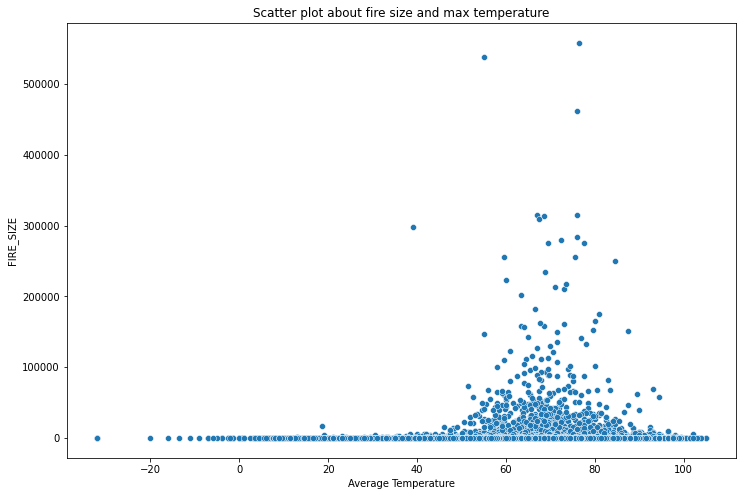

In [13]:
# scatter plot about fire size and max temperature
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x="TAVG", y="FIRE_SIZE")
plt.xlabel("Average Temperature")
plt.title("Scatter plot about fire size and max temperature")
plt.show()

In [9]:
df["LOG_AWND"] = np.log(df["AWND"])

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


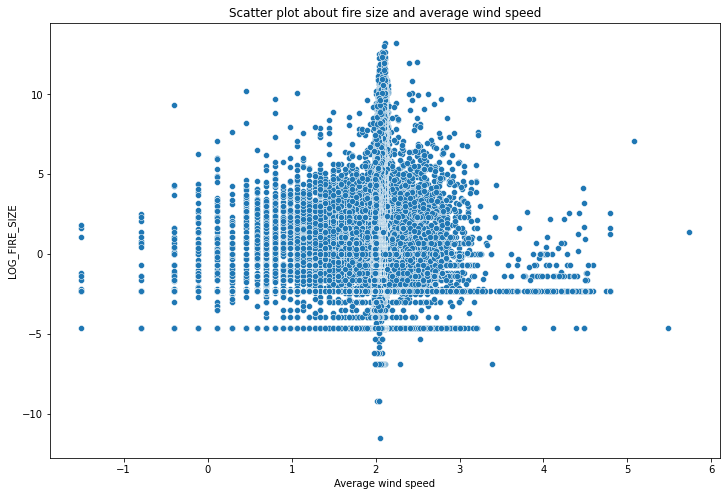

In [20]:
# scatter plot about fire size and wind speed
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x="LOG_AWND", y="LOG_FIRE_SIZE")
plt.xlabel("Log Average wind speed")
plt.title("Scatter plot about fire size and average wind speed")
plt.show()

In [21]:
count_wf = pd.DataFrame(df.groupby(["TMAX", "TMIN"]).size()).reset_index()

In [22]:
count_wf = count_wf.rename(columns={count_wf.columns[2]: 'count'})

In [23]:
def heatmap_bins(data, fieldsxy, ncuts=30, aggarg='mean'):
    """Perform data.groupby using bin cuts along columns named in fieldsxy.
    Args:
        data     - pandas dataframe
        fieldsxy - list of column names along which to perform binned groupby
        ncuts    - number of cuts to perform for each field (see pd.cut)
        aggarg   - aggregation operation to perform, default: 'mean'
    Returns:
        grouped dataframe, ready for plotting via sns.heatmap(means['COLUMNAME'])
    """
    # based on: https://matthewmcgonagle.github.io/blog/2019/01/22/HeatmapBins
    cuts = pd.DataFrame({str(feature) + ' bins' : pd.cut(data[feature], ncuts) for feature in fieldsxy})
    means = data.join(cuts).groupby( list(cuts) ).agg(aggarg)
    means = means.unstack(level = 0) # Use level 0 to put 0Bin as columns.
    # Reverse the order of the rows as the heatmap will print from top to bottom.
    means = means.iloc[::-1]
    return means

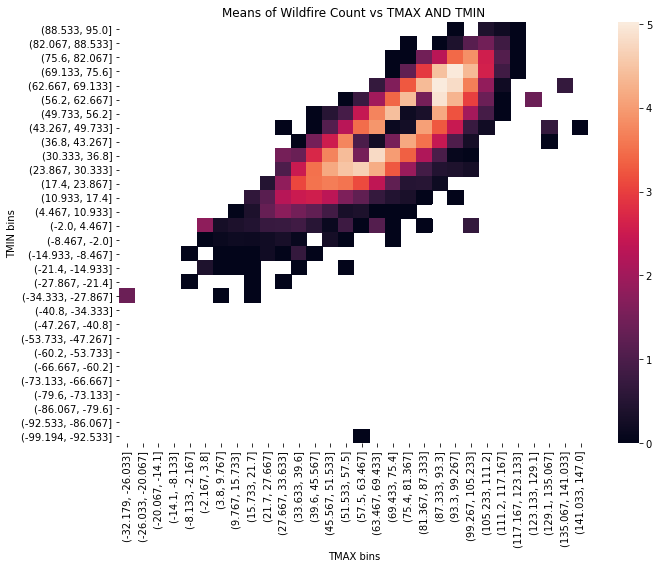

In [24]:
with plt.rc_context({'figure.figsize': (10,8)}):
    means = heatmap_bins(count_wf[["TMAX", "TMIN",'count']],["TMAX", "TMIN"])
    plt.clf()
sns.heatmap(np.log(means['count']))
plt.title('Means of Wildfire Count vs TMAX AND TMIN')
plt.tight_layout()

In [31]:
count_wf = pd.DataFrame(df.groupby(["TAVG", "AWND"]).size()).reset_index()

In [32]:
count_wf = count_wf.rename(columns={count_wf.columns[2]: 'count'})

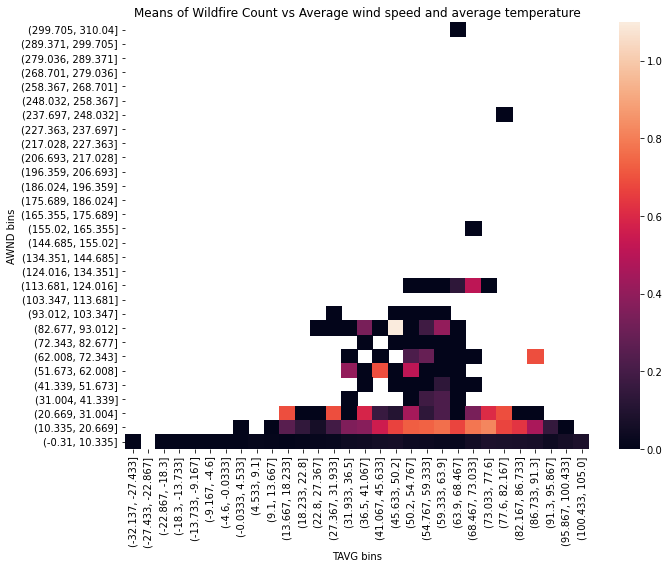

In [33]:
with plt.rc_context({'figure.figsize': (10,8)}):
    means = heatmap_bins(count_wf[["TAVG", "AWND","count"]],["TAVG", "AWND"])
    plt.clf()
sns.heatmap(np.log(means['count']))
plt.title('Means of Wildfire Count vs Average wind speed and average temperature')
plt.tight_layout()

In [10]:
df1 = df.groupby(["STATE", "month"])['TAVG'].mean().reset_index(name="avg_t")

In [12]:
df1

,STATE,month,avg_t
0,AK,1,11.000000
1,AK,2,12.750000
2,AK,3,22.833333
3,AK,4,40.142822
4,AK,5,52.137507
...,...,...,...
595,WY,8,65.146742
596,WY,9,59.908580
597,WY,10,52.810461
598,WY,11,47.476201


In [23]:
states = pd.unique(df1["STATE"]).tolist()
states

51

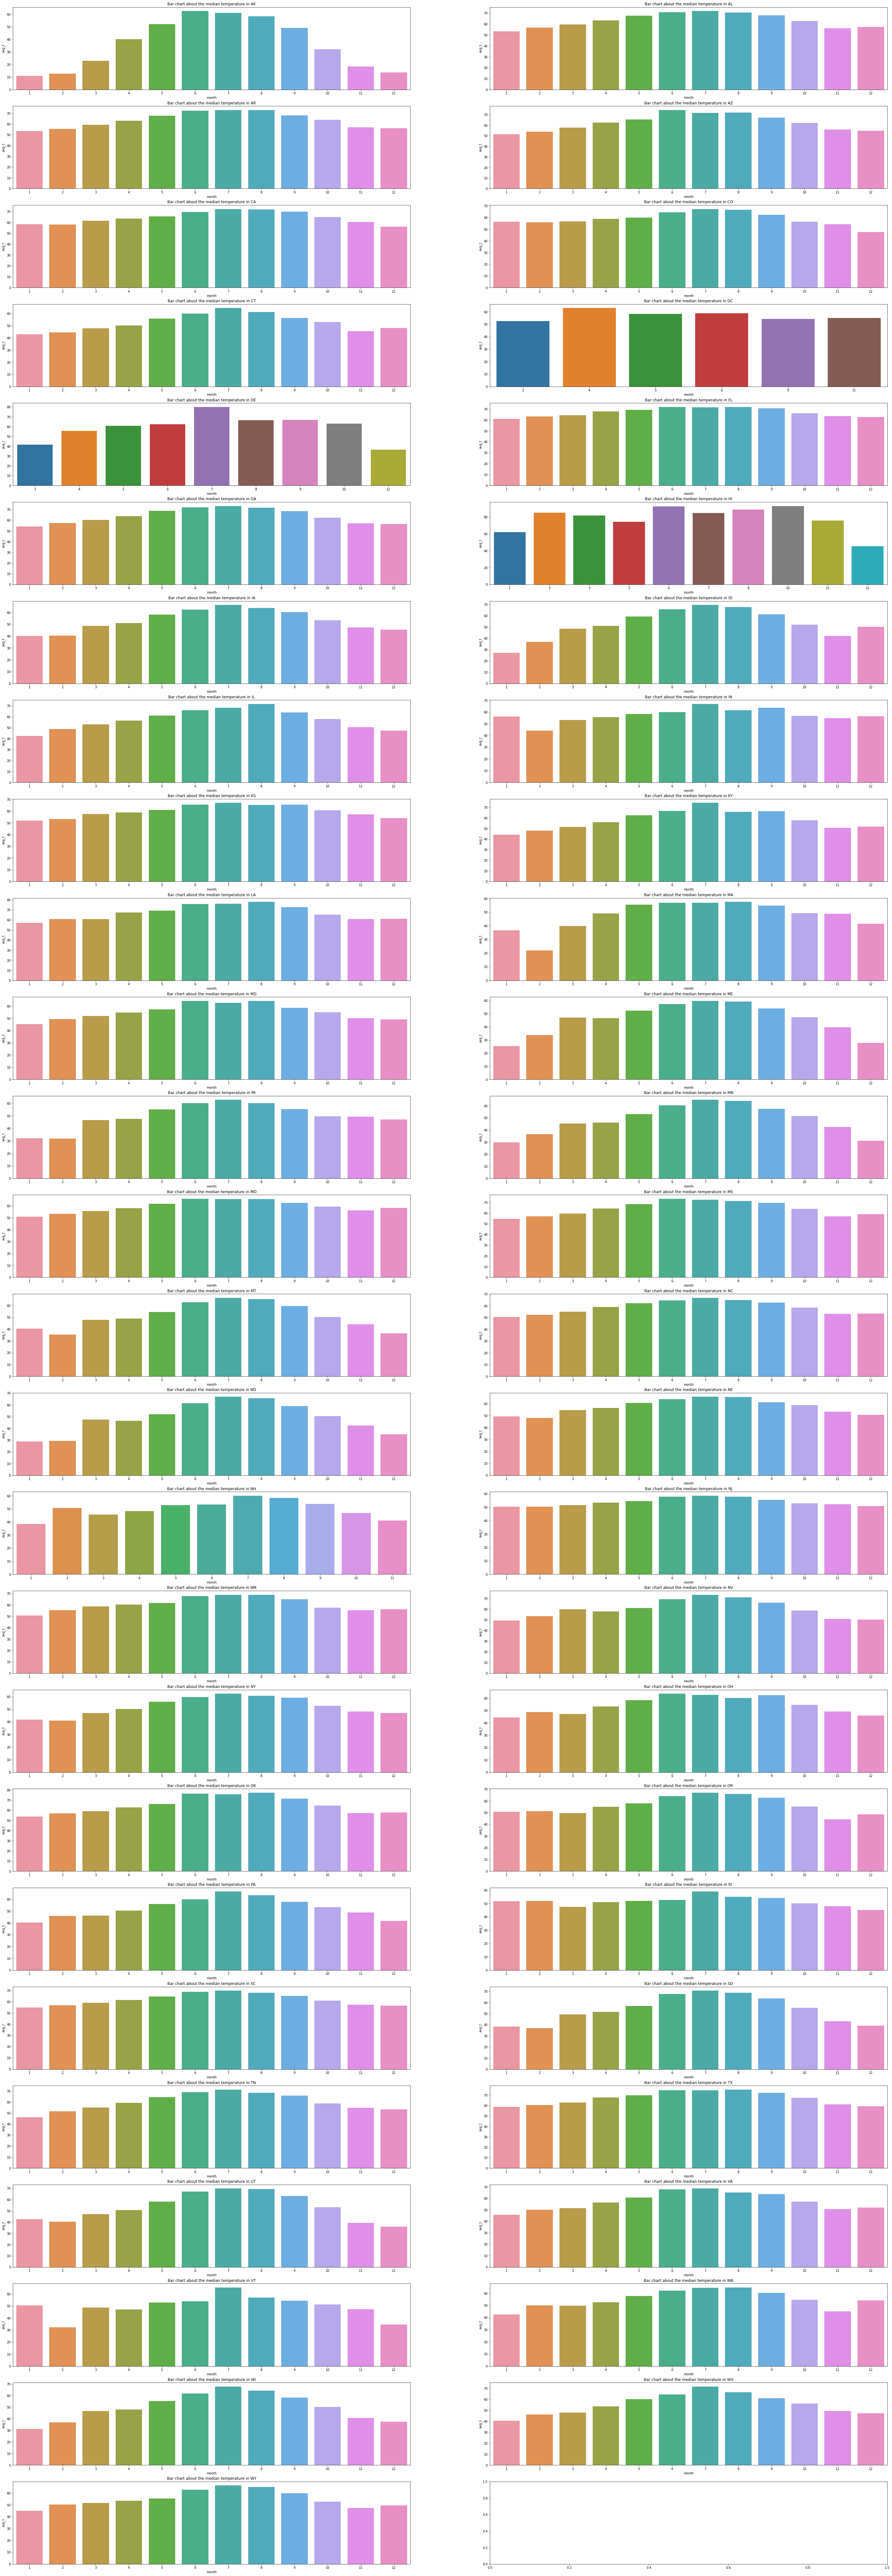

In [38]:

fig, axs = plt.subplots(26, 2, figsize=(50, 150))
for i in range(0, len(states)):
  row = i // 2
  column = i % 2
  state = states[i]
  temp_df = df1[(df1["STATE"]==state)].sort_values(by="month")
  sns.barplot(x="month", y="avg_t", data=temp_df, ax=axs[row][column])
  axs[row][column].set_title(f"Bar chart about the median temperature in {state}")  

In [39]:
df2 = df.groupby(["STATE", "month"])['AWND'].mean().reset_index(name="avg_w")

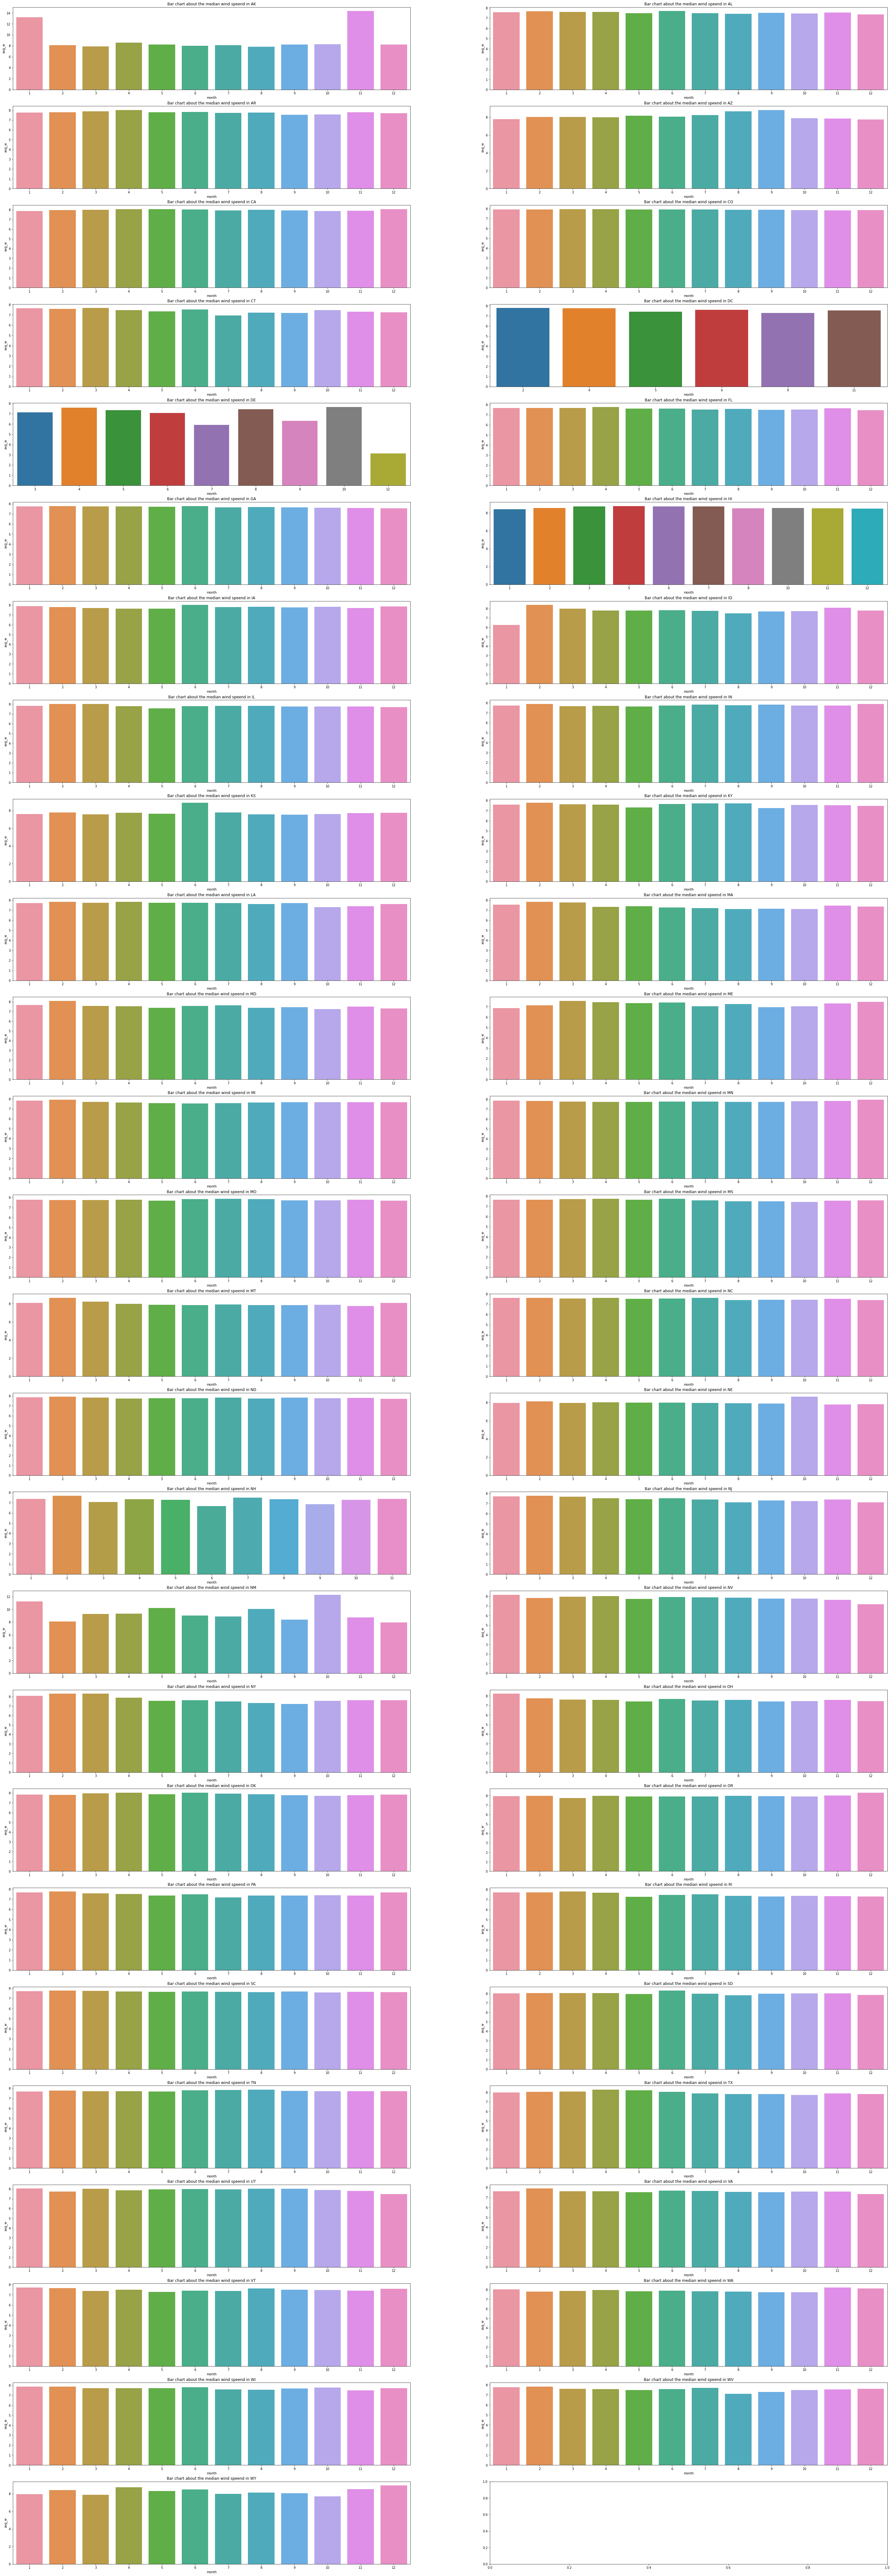

In [40]:
fig, axs = plt.subplots(26, 2, figsize=(50, 150))
for i in range(0, len(states)):
  row = i // 2
  column = i % 2
  state = states[i]
  temp_df = df2[(df2["STATE"]==state)].sort_values(by="month")
  sns.barplot(x="month", y="avg_w", data=temp_df, ax=axs[row][column])
  axs[row][column].set_title(f"Bar chart about the median wind speend in {state}")  